# Need to fix the CES code

In [1]:
using CairoMakie, Dierckx, QuantEcon, LinearAlgebra, Optim

In [8]:
pars = (;r = 0.04, # interest rate
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 31, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    lb = 0.0, # lower bound of capital grid
    ub = 2000.0) # upper bound of capital grid

(r = 0.04, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 31, θ = 4.0, toler = 4.0e-7, maxiter = 1000, lb = 0.0, ub = 2000.0)

In [9]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1.0
        return log(c)
    else
        return c^(1-γ)/(1-γ)
    end
end

function ar1(pars)
    (;ρ, μ, σ, nz) = pars
    mc = QuantEcon.rouwenhorst(nz, μ, ρ, σ)
    return mc.p, mc.state_values
end

function exp_grid(pars)
    (; na, θ, lb, ub) = pars
    grid = LinRange(0.0,1.0,na)
    exp_grid = lb .+ (ub - lb) .* grid.^θ
    return exp_grid
end

function resources(Avals, Zvals, j, i, pars)
    (; r) = pars
    return (1+r)*Avals[j] + exp(Zvals[i])
end

function interpV(Avals, v_slice)
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    return interp_v
end

function optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
    (; β, na, nz, lb) = pars
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV(Avals, expected_value)
        for j in 1:na
            obj(ap) = - (utility(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))
            ub = resources(Avals, Zvals, j, i, pars)  
            res = optimize(obj, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

optimise (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 1.0
--------------------
Iteration: 10, Error: 0.08414095463590016
--------------------
Iteration: 20, Error: 0.026471162510157995
--------------------
Iteration: 30, Error: 0.01011591059022457
--------------------
Iteration: 40, Error: 0.004086549452438676
--------------------
Iteration: 50, Error: 0.0016704203267484717
--------------------
Iteration: 60, Error: 0.0006792104414623221
--------------------
Iteration: 70, Error: 0.00027250091972184584
--------------------
Iteration: 80, Error: 0.00010754784299437292
--------------------
Iteration: 90, Error: 4.17254870011986e-5
--------------------
Iteration: 100, Error: 1.591832270048107e-5
--------------------
Iteration: 110, Error: 5.985726617759103e-6
--------------------
Iteration: 120, Error: 2.2195369539148902e-6
--------------------
Iteration: 130, Error: 8.131345041592221e-7
--------------------
Converged in 139 iterations
--------------------
  1.377084 seconds (1.88 M allo

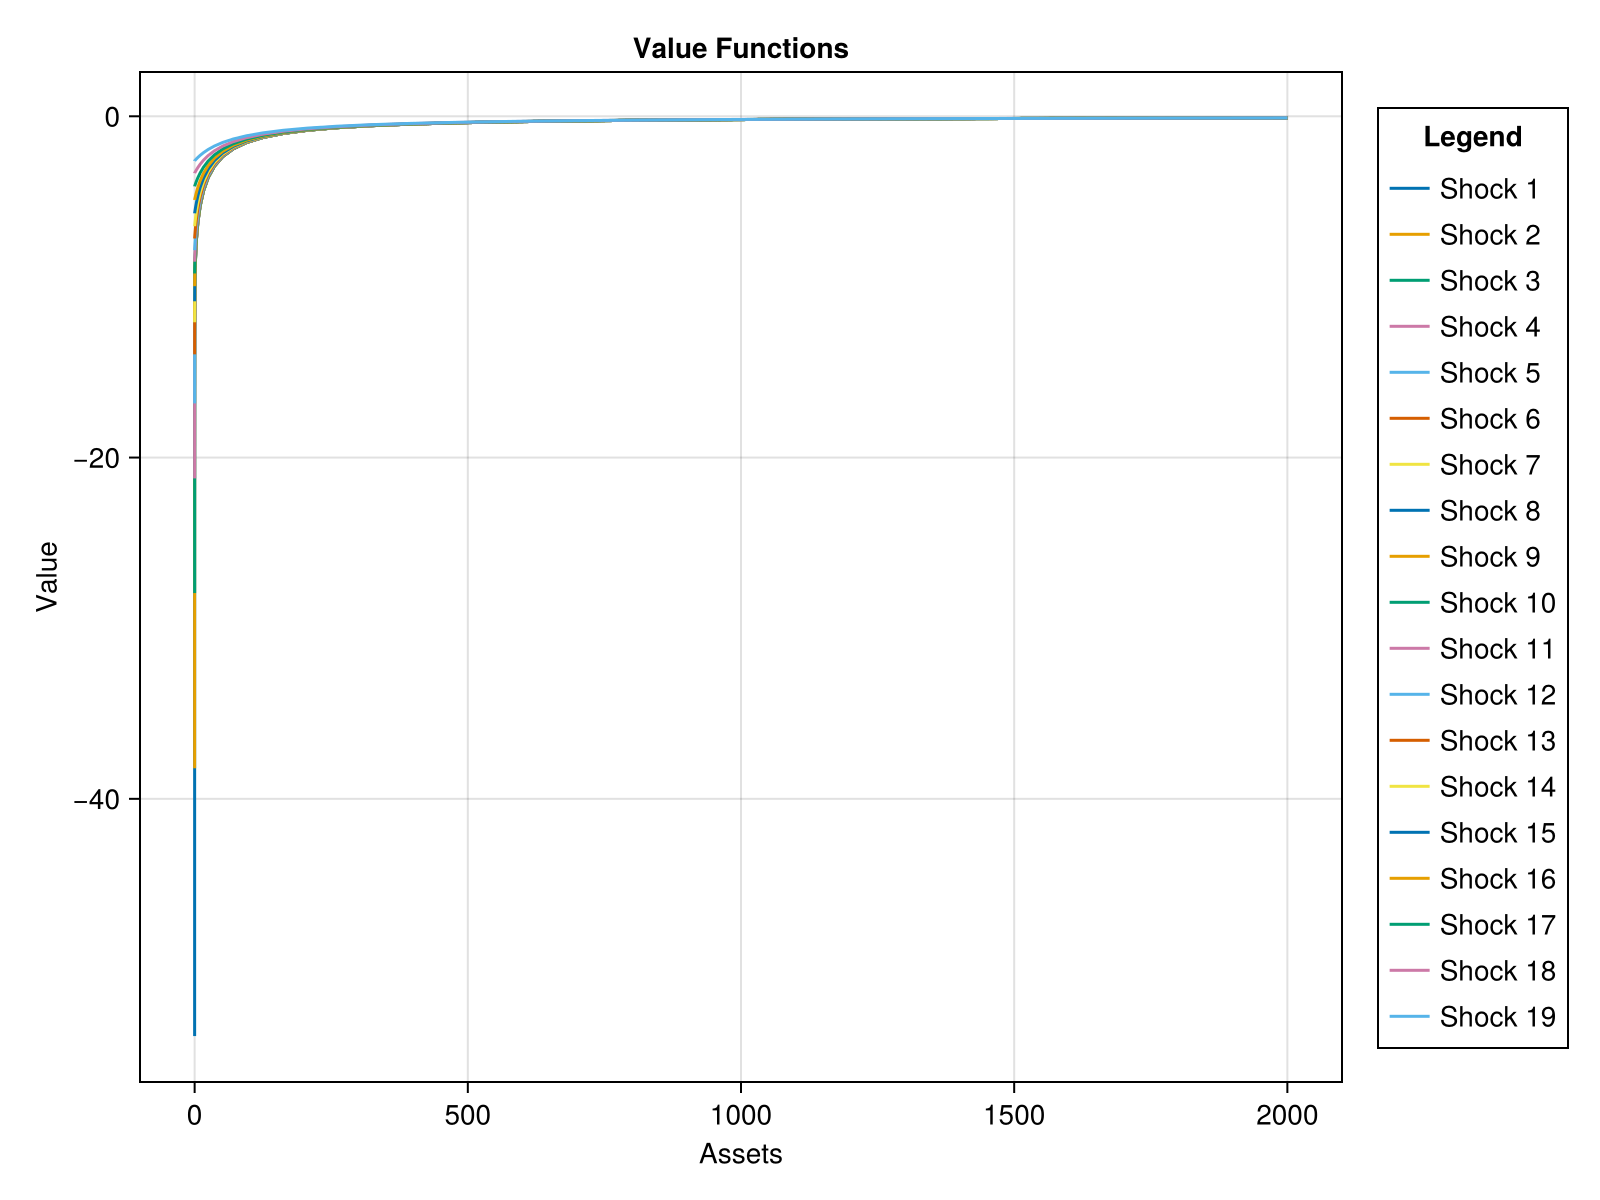

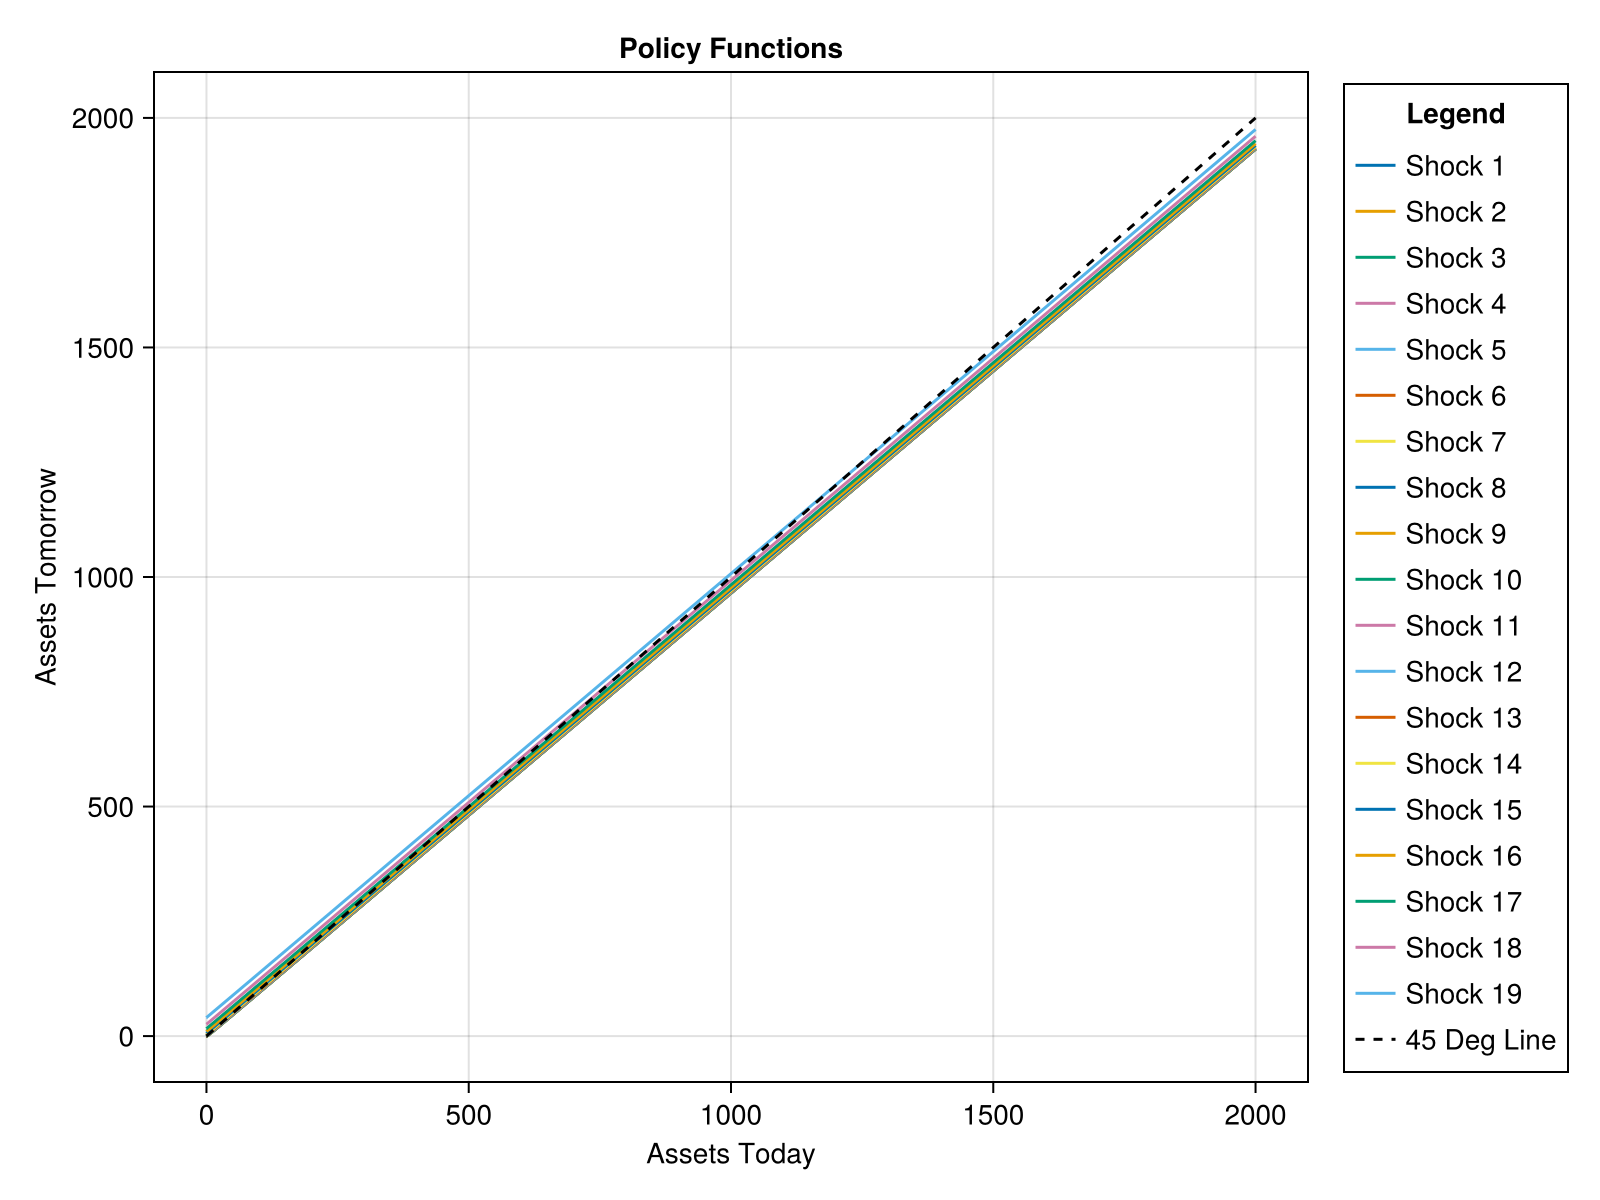

([-53.904238076103425 -38.209364235988396 … -3.328770897254759 -2.60978436967267; -49.16522854818944 -36.10489576509166 … -3.3286183893240078 -2.6096940439616554; … ; -0.11088342034394241 -0.1108827236005395 … -0.10912576320031929 -0.10821926104841245; -0.09710721872777314 -0.097106686248236 … -0.09575934435359204 -0.09506028684004915], [2.4303178043978093e-16 4.4032336061626624e-16 … 25.77441382030032 40.335211033150145; 2.9746371272582896e-16 2.5214955649209746e-16 … 25.776781249736153 40.33758300888882; … ; 1686.987492690498 1686.9982991170953 … 1714.6963549716954 1729.347776720568; 1932.1598485472734 1932.170725201991 … 1960.0860453915834 1974.8838999327677])

In [10]:
function vfi(v_init, pars)
    (; maxiter, toler, nz, na) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % 10 == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v_init = ones(pars.na, pars.nz)

@time begin
v_out, pol_out = vfi(v_init, pars)
end

In [11]:
function utility_EZ(c, p)
    (; γ) = p
    return c^(1-γ)
end

function interpV_EZ(Avals, v_slice, p)
    (; γ) = p
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    transformed_interp(x) = interp_v(x)^(1.0-pars.γ)
    return transformed_interp
end

function optimise_EZ(Avals, Zvals, v_init, v_new, policy, Π, p)
    (; β, na, nz, lb, γ) = p
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV_EZ(Avals, expected_value, p)
        for j in 1:na
            obj_EZ(ap) = - (((1-β) * utility_EZ(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))^(1/(1-γ)))
            ub = resources(Avals, Zvals, j, i, p)  
            res = optimize(obj_EZ, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

optimise_EZ (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 0.8161556844308419
--------------------
Iteration: 10, Error: 0.31035869012617434
--------------------
Iteration: 20, Error: 0.8129176018317334
--------------------
Iteration: 30, Error: 1.797325224669592
--------------------
Iteration: 40, Error: 2.7653916320976393
--------------------
Iteration: 50, Error: 2.479463777262694
--------------------
Iteration: 60, Error: 1.3510326277110494
--------------------
Iteration: 70, Error: 0.5475177331974095
--------------------
Iteration: 80, Error: 0.19334199441105682
--------------------
Iteration: 90, Error: 0.06386636769404674
--------------------
Iteration: 100, Error: 0.02015245980165048
--------------------
Iteration: 110, Error: 0.006076148077198695
--------------------
Iteration: 120, Error: 0.001748579704511144
--------------------
Iteration: 130, Error: 0.0004947791590836914
--------------------
Iteration: 140, Error: 0.00014941143678015578
--------------------
Iteration: 150, Err

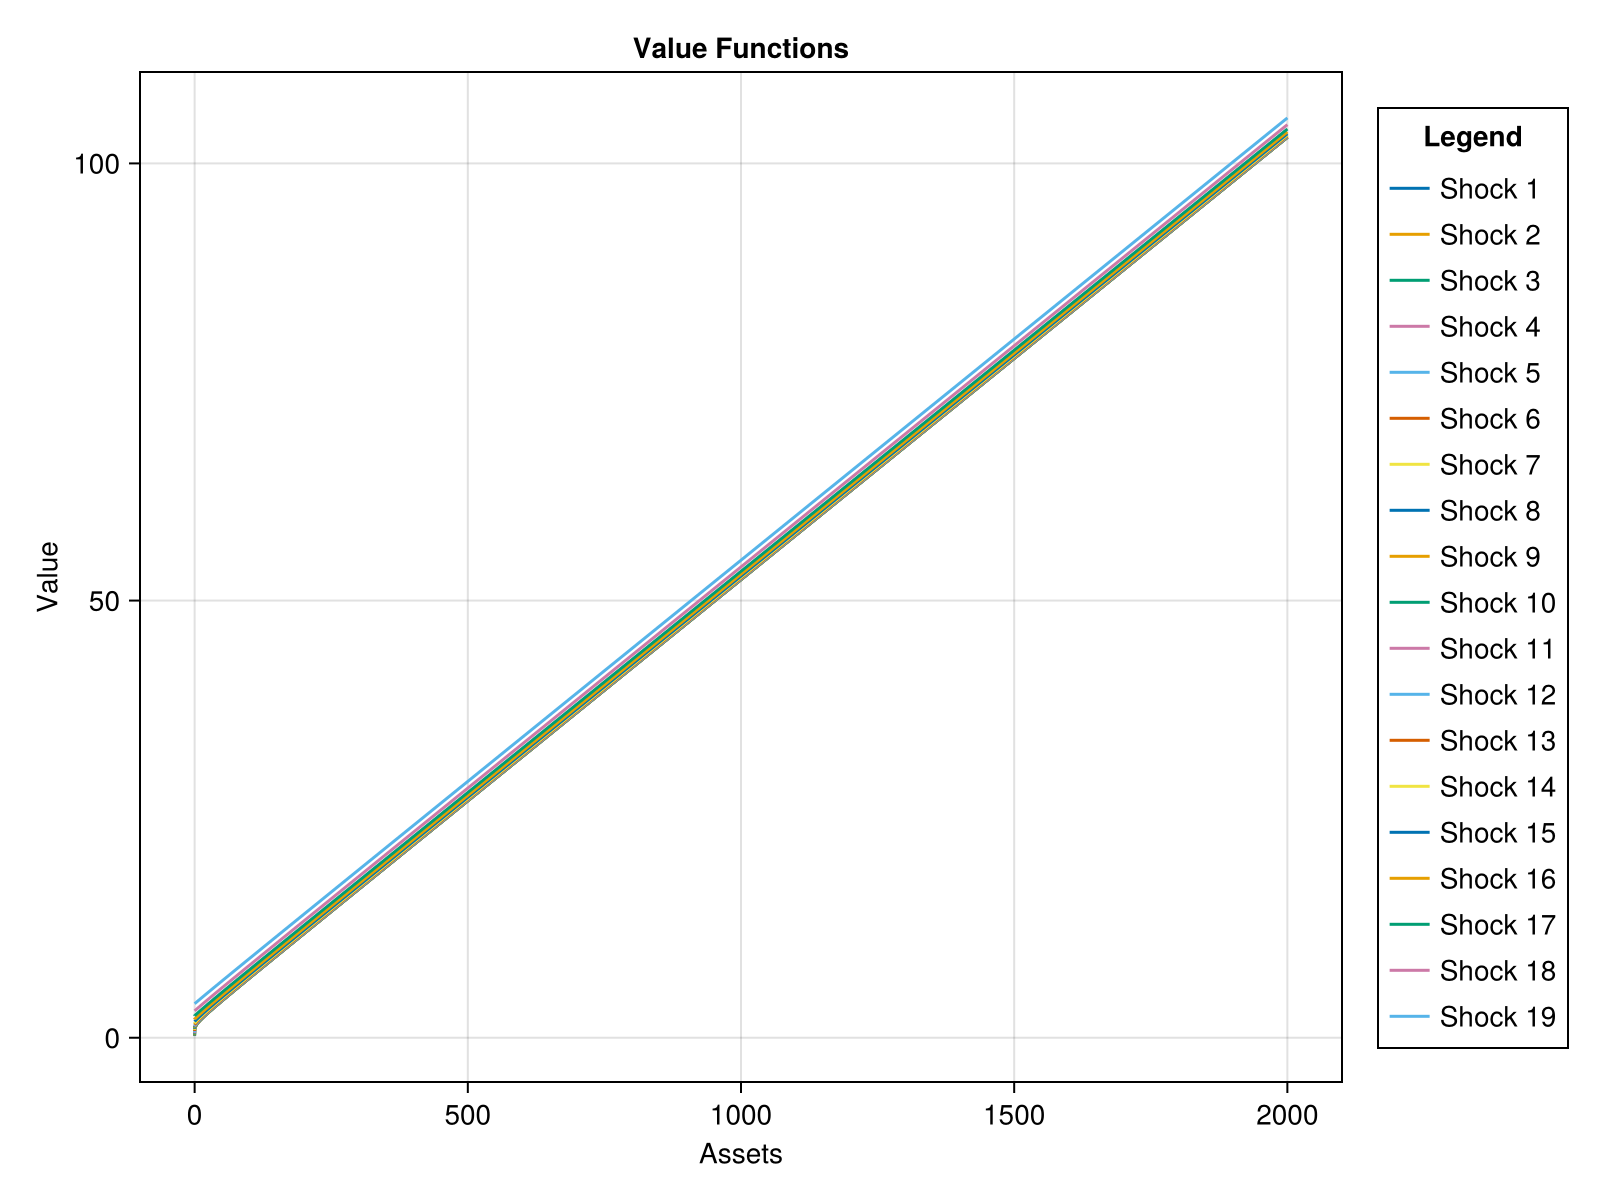

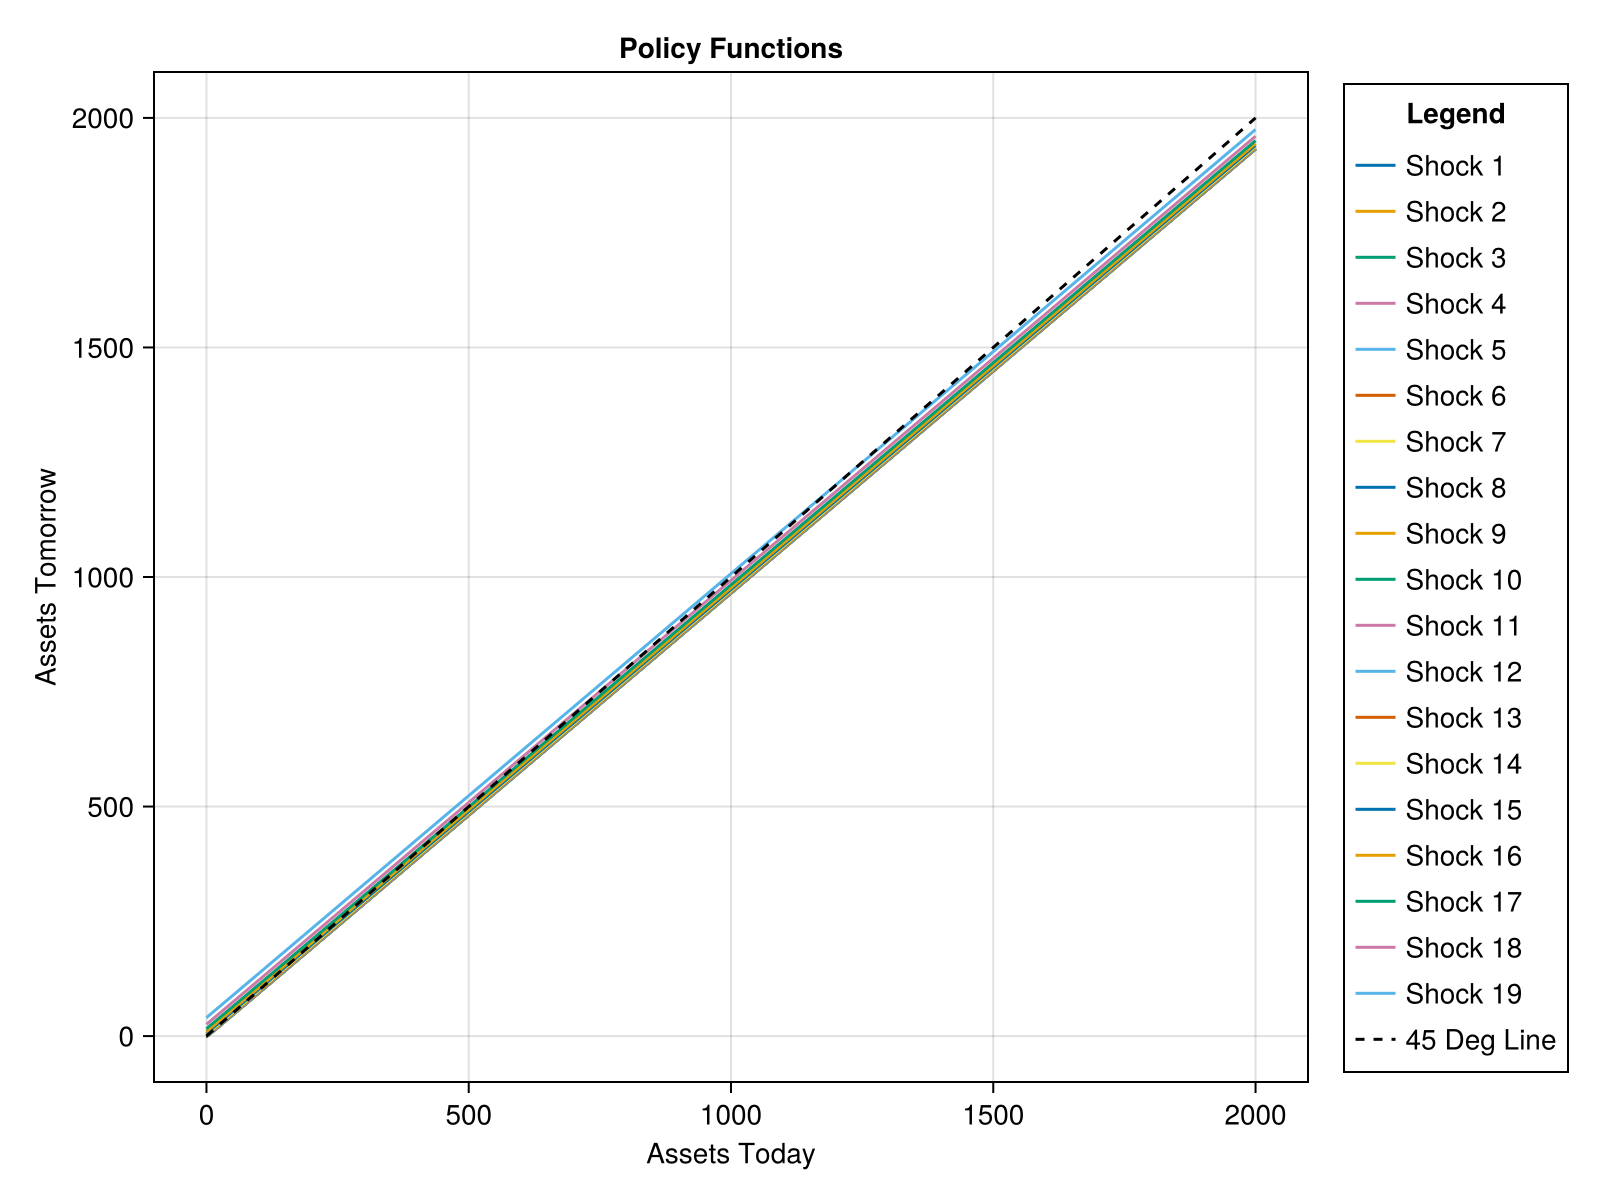

([0.18895509433414354 0.2686168011438645 … 3.07347262965215 3.8917163661261225; 0.20753941898916337 0.2847114116514968 … 3.073608408488486 3.8918474482540573; … ; 90.1544324597493 90.15499869591314 … 91.60656007524445 92.37452418270117; 102.98377709223472 102.98434332148221 … 104.43588748900657 105.20384290972751], [3.5181593885267114e-16 3.200489815799136e-16 … 25.65100356606808 40.220020942692166; 3.9600757145084753e-16 3.605831793078348e-16 … 25.65336702794254 40.22239519213734; … ; 1686.9797293383206 1686.9905591620766 … 1714.7531253899924 1729.4412295528616; 1932.3554010709718 1932.366230909243 … 1960.1288426622903 1974.816971158231])

In [13]:
function vfi_EZ(v_init, p)
    (; maxiter, toler, nz, na) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_EZ(Avals, Zvals, v_init, v_new, policy, Π, p)
        error = maximum(abs.(v_new - v_init))
        v_init .= v_new
        if iter % 10 == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

p = (;r = 0.04, # interest rate
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 31, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    lb = 0.0, # lower bound of capital grid
    ub = 2000.0) # upper bound of capital grid

v2 = ones(p.na, p.nz)

@time begin
v_out, pol_out = vfi_EZ(v2, p)
end